# Using Liquid Neural Networks to create Robust model without need for overparametrisation

A robust model, in the context of machine learning, refers to a model that is able to generalize well and perform reliably in various situations, even when faced with unexpected or noisy data. Robust models are designed to handle outliers, errors, or variations in the input data without significantly compromising their performance.

In [1]:
# Install dependencies if they are not installed yet
!pip install ncps

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 532.0 kB/s eta 0:00:00


In [7]:
import numpy as np
import os
from tensorflow import keras
from ncps import wirings
from ncps.tf import LTC
import matplotlib.pyplot as plt
import seaborn as sns

data_x.shape:  (1, 500, 2)
data_t.shape:  (1, 500, 1)
data_y.shape:  (1, 500, 1)


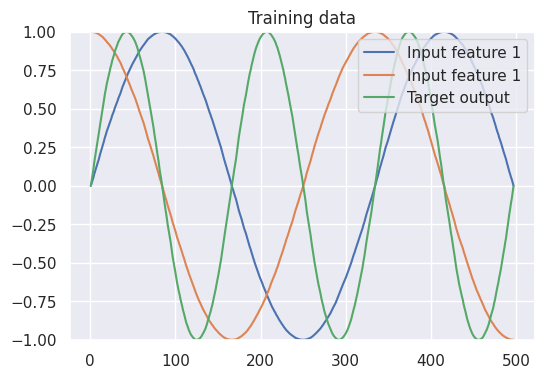

In [37]:
N = 500 # Length of the time-series
# Input feature is a sine and a cosine wave
data_x = np.stack(
    [np.sin(np.linspace(0, 3 * np.pi, N)), np.cos(np.linspace(0, 3 * np.pi, N))], axis=1
)
data_x = np.expand_dims(data_x, axis=0).astype(np.float32)  # Add batch dimension
data_t = np.random.default_rng().uniform(0.8,1.2, size=(1,N,1))
# Irregularly sampled time (uniform between 0.8 and 1.2 seconds)
# Target output is a sine with double the frequency of the input signal
data_y = np.sin(np.linspace(0, 6 * np.pi, N)).reshape([1, N, 1]).astype(np.float32)
print("data_x.shape: ", str(data_x.shape))
print("data_t.shape: ", str(data_t.shape))
print("data_y.shape: ", str(data_y.shape))

# Let's visualize the training data
plt.figure(figsize=(6, 4))
# To conver the relative time steps into absolute time, 
# we have to do a "cumulative summation" (np.cumsum)
plt.plot(np.cumsum(data_t[0,:,0]), data_x[0, :, 0], label="Input feature 1")
plt.plot(np.cumsum(data_t[0,:,0]), data_x[0, :, 1], label="Input feature 1")
plt.plot(np.cumsum(data_t[0,:,0]), data_y[0, :, 0], label="Target output")
plt.ylim((-1, 1))
plt.title("Training data")
plt.legend(loc="upper right")
plt.show()


In [38]:
train_ratio = 0.8  # 80% for training, 20% for testing

# Calculate the split index
split_index = int(data_x.shape[1] * train_ratio)

# Split the data into train and test sets
train_x = data_x[:, :split_index, :]
train_t = data_t[:, :split_index, :]
train_y = data_y[:, :split_index, :]

test_x = data_x[:, split_index:, :]
test_t = data_t[:, split_index:, :]
test_y = data_y[:, split_index:, :]

# Print the shapes of train and test sets
print("Train shapes:")
print("train_x.shape:", train_x.shape)
print("train_t.shape:", train_t.shape)
print("train_y.shape:", train_y.shape)
print()
print("Test shapes:")
print("test_x.shape:", test_x.shape)
print("test_t.shape:", test_t.shape)
print("test_y.shape:", test_y.shape)

Train shapes:
train_x.shape: (1, 400, 2)
train_t.shape: (1, 400, 1)
train_y.shape: (1, 400, 1)

Test shapes:
test_x.shape: (1, 100, 2)
test_t.shape: (1, 100, 1)
test_y.shape: (1, 100, 1)


In [39]:
wiring = wirings.AutoNCP(12,1) # 8 neurons in total, 1 output (motor neuron)
model = keras.models.Sequential(
    [
        keras.layers.InputLayer(input_shape=(None, 2)),
        # here we could potentially add layers before and after the LTC network
        LTC(wiring, return_sequences=True),
    ]
)
model.compile(
    optimizer=keras.optimizers.Adam(0.01), loss='mean_squared_error'
)

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 ltc_3 (LTC)                 (None, None, 1)           714       
                                                                 
Total params: 714
Trainable params: 714
Non-trainable params: 0
_________________________________________________________________


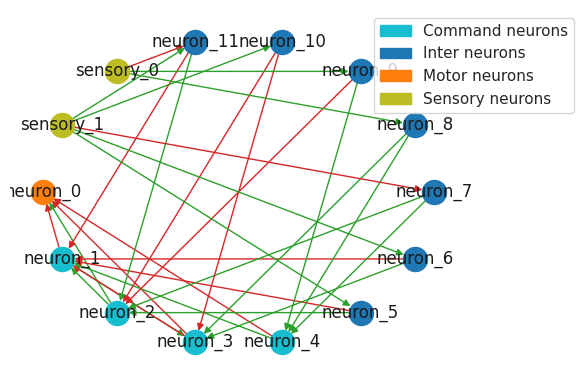

In [40]:
sns.set_style("white")
plt.figure(figsize=(6, 4))
legend_handles = wiring.draw_graph(draw_labels=True, neuron_colors={"command": "tab:cyan"})
plt.legend(handles=legend_handles, loc="upper center", bbox_to_anchor=(1, 1))
sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.show()

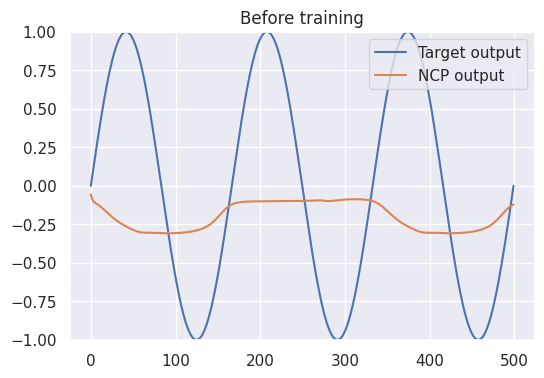

In [41]:
# Let's visualize how LTC initialy performs before the training
sns.set()
prediction = model(data_x).numpy()
plt.figure(figsize=(6, 4))
plt.plot(data_y[0, :, 0], label="Target output")
plt.plot(prediction[0, :, 0], label="NCP output")
plt.ylim((-1, 1))
plt.title("Before training")
plt.legend(loc="upper right")
plt.show()

In [42]:
# Train the model for 400 epochs (= training steps)
hist = model.fit(x=train_x, y=train_y, batch_size=1, epochs=400,verbose=1)

Epoch 1/400
1/1 [==============================] - 6s 6s/step - loss: 0.6098
Epoch 2/400
1/1 [==============================] - 0s 477ms/step - loss: 0.5625
Epoch 3/400
1/1 [==============================] - 1s 552ms/step - loss: 0.5329
Epoch 4/400
1/1 [==============================] - 1s 823ms/step - loss: 0.5148
Epoch 5/400
1/1 [==============================] - 1s 798ms/step - loss: 0.5040
Epoch 6/400
1/1 [==============================] - 1s 785ms/step - loss: 0.4978
Epoch 7/400
1/1 [==============================] - 1s 589ms/step - loss: 0.4948
Epoch 8/400
1/1 [==============================] - 0s 490ms/step - loss: 0.4938
Epoch 9/400
1/1 [==============================] - 0s 472ms/step - loss: 0.4941
Epoch 10/400
1/1 [==============================] - 0s 473ms/step - loss: 0.4952
Epoch 11/400
1/1 [==============================] - 1s 503ms/step - loss: 0.4962
Epoch 12/400
1/1 [==============================] - 0s 484ms/step - loss: 0.4969
Epoch 13/400
1/1 [======================

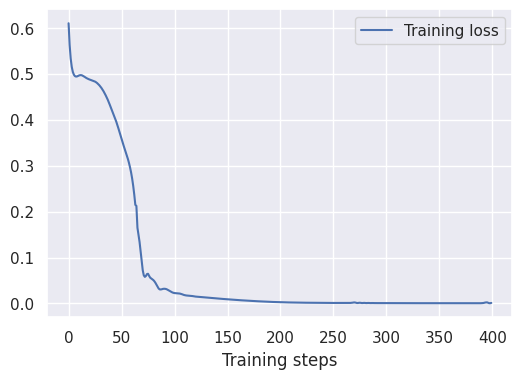

In [43]:
# Let's visualize the training loss
sns.set()
plt.figure(figsize=(6, 4))
plt.plot(hist.history["loss"], label="Training loss")
plt.legend(loc="upper right")
plt.xlabel("Training steps")
plt.show()

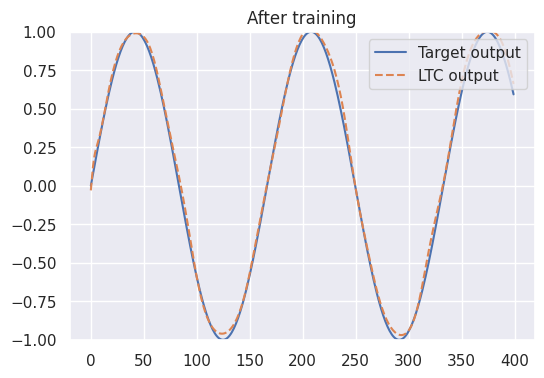

In [44]:
# How does the trained model now fit to the sinusoidal function?
prediction = model(train_x).numpy()
plt.figure(figsize=(6, 4))
plt.plot(train_y[0, :, 0], label="Target output")
plt.plot(prediction[0, :, 0], label="LTC output",linestyle="dashed")
plt.ylim((-1, 1))
plt.legend(loc="upper right")
plt.title("After training")
plt.show()

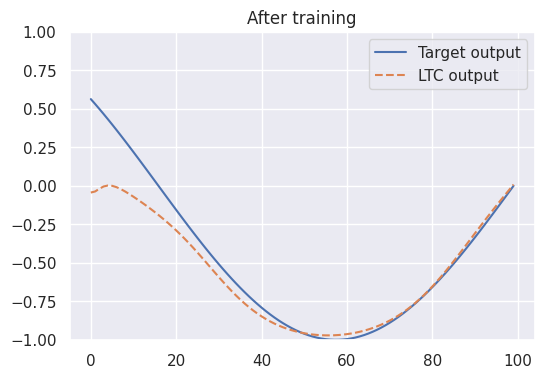

In [48]:
# How does the trained model now fit to the sinusoidal function?
prediction = model(test_x).numpy()
plt.figure(figsize=(6, 4))
plt.plot(test_y[0, :, 0], label="Target output")
plt.plot(prediction[0, :, 0], label="LTC output",linestyle="dashed")
plt.ylim((-1, 1))
plt.legend(loc="upper right")
plt.title("After training")
plt.show()

In [49]:
from sklearn.metrics import mean_absolute_error

# Assuming you have the following data
target_output = test_y[0, :, 0]
predicted_output = prediction[0, :, 0]

# Calculate the MAE error
mae = mean_absolute_error(target_output, predicted_output)

# Print the MAE error
print("MAE Error:", mae)


MAE Error: 0.09446373


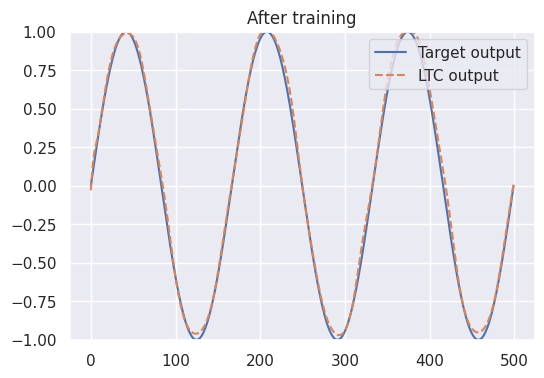

In [50]:
# How does the trained model now fit to the sinusoidal function?
prediction = model(data_x).numpy()
plt.figure(figsize=(6, 4))
plt.plot(data_y[0, :, 0], label="Target output")
plt.plot(prediction[0, :, 0], label="LTC output",linestyle="dashed")
plt.ylim((-1, 1))
plt.legend(loc="upper right")
plt.title("After training")
plt.show()

In [52]:
from sklearn.metrics import mean_absolute_error

# Assuming you have the following data
target_output = data_y[0, :, 0]
predicted_output = prediction[0, :, 0]

# Calculate the MAE error
mae = mean_absolute_error(target_output, predicted_output)

# Print the MAE error
print("MAE Error:", mae)


MAE Error: 0.032542136


# Interesting thing: error on whole dataset is 3 times lower than error on test set